In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('legend', fontsize=16)
matplotlib.rcParams['savefig.dpi'] = 1200
# from utils_carryover import theta1, theta2
from utils_nonadaptive import run_nonadaptive
from utils_empirical import *
from utils_import_data import *

import pickle

%load_ext autoreload
%autoreload 2
import time

In [2]:
out_dir = "../result/"
out_path = out_dir 

## Run synthetic nonadaptive experiment on the flu data

Import flu data

The duration of carryover effects $\ell = 2$, where $\tau_0 + \tau_1 + \tau_2 = - 0.1\bar{Y}$ 

In [3]:
color_palette_dict = geval_color_palette()

Y = import_MS_FLU_pos_data()
tau_ratio = -0.1
lag = 2
all_taus = (1+lag - np.array(range(lag+1))); all_taus = all_taus/np.sum(all_taus); all_taus = list(np.mean(Y)*tau_ratio * all_taus)
all_taus = [4, -2, -1]; all_taus = all_taus/np.sum(all_taus); all_taus = list(np.mean(Y)*tau_ratio * all_taus)
tau_total = np.mean(Y)*tau_ratio

The experiment duration is $T = 7$, and the duration of historical data is $T_{\mathrm{hist}} = 14$

The simulation is run for 2000 iterations

In the stratified nonlinear optimal design, the number of strata is 4

In [4]:
T = 7; num_mc=2000; print_epochs = 100; pre_T = 14
G = 4; J = 1; adj_pct=0.02
all_Ns = [25,30,35,40,45,50];
result_gls = dict()
for N in all_Ns:
    params = (T, np.sum(all_taus))
    np.random.seed(123)
    print(N)
    idx_N_list, idx_T_list, shuffle_list = sample_flu_subblocks(Y, N, T, num_mc=num_mc, pre_T=pre_T)
    pre_Ys, all_Ys = get_all_pre_Ys(Y, idx_N_list, idx_T_list, shuffle_list, pre_T)

    # compare Z_ba, Z_ff, Z_ffba and Z_opt
    out_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, adjust_covar=False, return_std=True, method="GLS", adj_pct=adj_pct)

    # compare Z_stratified,opt
    this_dict, _, _, _ = run_nonadaptive(all_taus, all_Ys=all_Ys, pre_Ys=pre_Ys, print_epochs=print_epochs, J=J, G=G, 
                                                  adjust_covar=True, adjust_covar_only = True, return_std=True, method="GLS", adj_pct=adj_pct)
    out_dict['opt+_'+str(J)+"_"+str(G)] = this_dict['opt+_'+str(J)+"_"+str(G)]
    result_gls[N] = out_dict

25
100/2000 done
200/2000 done
300/2000 done
400/2000 done
500/2000 done
600/2000 done
700/2000 done
800/2000 done
900/2000 done
1000/2000 done
1100/2000 done
1200/2000 done
1300/2000 done
1400/2000 done
1500/2000 done
1600/2000 done
1700/2000 done
1800/2000 done
1900/2000 done
2000/2000 done
100/2000 done
200/2000 done
300/2000 done
400/2000 done
500/2000 done
600/2000 done
700/2000 done
800/2000 done
900/2000 done
1000/2000 done
1100/2000 done
1200/2000 done
1300/2000 done
1400/2000 done
1500/2000 done
1600/2000 done
1700/2000 done
1800/2000 done
1900/2000 done
2000/2000 done
30
100/2000 done
200/2000 done
300/2000 done
400/2000 done
500/2000 done
600/2000 done
700/2000 done
800/2000 done
900/2000 done
1000/2000 done
1100/2000 done
1200/2000 done
1300/2000 done
1400/2000 done
1500/2000 done
1600/2000 done
1700/2000 done
1800/2000 done
1900/2000 done
2000/2000 done
100/2000 done
200/2000 done
300/2000 done
400/2000 done
500/2000 done
600/2000 done
700/2000 done
800/2000 done
900/2000 

save data

In [5]:
save_path = out_dir + "/flu/flu_mse_varying_N.pkl"
with open(save_path, 'wb') as handle:
    pickle.dump(result_gls, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Make Figure 6 in the paper

results for the left subplot to compare $Z_{\mathrm{ff}}$, $Z_{\mathrm{ba}}$, $Z_{\mathrm{ffba}}$, and $Z_{\mathrm{opt}}$

In [6]:
result = result_gls
out = dict()
N_col = '$N$'; method_col = '$\mathrm{design}$'
method_dict = {'ff': '$Z_{\mathrm{ff}}$', 'ba': '$Z_{\mathrm{ba}}$', 'ffba': '$Z_{\mathrm{ffba}}$', 'opt_0': '$Z_{\mathrm{opt,linear}}$', 'opt': '$Z_{\mathrm{opt}}$'}
out[N_col] = list()
out[method_col] = list()
for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out[this_val_col] = list()

for N in all_Ns:
    for name in ['ff', 'ba', 'ffba', 'opt']:
        out[N_col] = out[N_col] + [N] * len(result[N][name])
        out[method_col] = out[method_col] + [method_dict[name]] * len(result[N][name])
        for idx in range(lag+1):
            this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
            out[this_val_col] = out[this_val_col] + list((np.array(result[N][name])[:,idx] - all_taus[lag-idx]))
        


out_df = pd.DataFrame(out)
total_val_col = '$(\sum_{j}\hat{\\tau}_{j}-\sum_{j}\\tau_{j})^2$'
out_df[total_val_col] = 0 
for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out_df[total_val_col] = out_df[total_val_col] + out_df[this_val_col]

out_df[total_val_col] = out_df[total_val_col] ** 2
out_df.iloc[:,2:] = out_df.iloc[:,2:] * 1e6

val = np.quantile(out_df.loc[(out_df[method_col] == method_dict['ff'])].iloc[:,-1], 0.97)
out_df = out_df.loc[((out_df[method_col] == method_dict['ff']) & ((out_df[N_col] == 35) | (out_df[N_col] == 45)) & (out_df[total_val_col] <= val)) | (out_df[method_col] != method_dict['ff']) | ((out_df[N_col] != 35) & (out_df[N_col] != 45))]

out_df_flu_basic = out_df

results for the right subplot to compare $Z_{\mathrm{opt,linear}}$, $Z_{\mathrm{opt}}$, and $Z_{\mathrm{opt,stratified}}$

In [7]:
out = dict()
N_col = '$N$'; method_col = '$\mathrm{design}$'
method_dict = {'ff': '$Z_{\mathrm{ff}}$', 'ba': '$Z_{\mathrm{ba}}$', 'ffba': '$Z_{\mathrm{ffba}}$', 'opt_0': '$Z_{\mathrm{opt,linear}}$', 
               'opt': '$Z_{\mathrm{opt}}$'}
method_dict['opt+_'+str(J)+'_'+str(G)] = '$Z_{\mathrm{opt,stratified}}$'
out[N_col] = list()
out[method_col] = list()
for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out[this_val_col] = list()

for N in all_Ns:
    for name in ['opt_0','opt']:
        out[N_col] = out[N_col] + [N] * len(result[N][name])
        out[method_col] = out[method_col] + [method_dict[name]] * len(result[N][name])
        for idx in range(lag+1):
            this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
            out[this_val_col] = out[this_val_col] + list((np.array(result[N][name])[:,idx] - all_taus[lag-idx])**2)

    name = 'opt+_'+str(J)+'_'+str(G)
    out[N_col] = out[N_col] + [N] * len(result[N][name])
    out[method_col] = out[method_col] + [method_dict[name]] * len(result[N][name])
    for idx in range(lag+1):
        this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
        out[this_val_col] = out[this_val_col] + list((np.array(result[N][name])[:,idx] - all_taus[lag-idx])**2)
    

out_df = pd.DataFrame(out)
total_val_col = '$(\sum_{j}\hat{\\tau}_{j}-\sum_{j}\\tau_{j})^2$'
out_df[total_val_col] = 0 
for idx in range(lag+1):
    this_val_col = '$(\hat{\\tau}_{\mathrm{'+str(idx)+'}}-\\tau_{\mathrm{'+str(idx)+'}})^2$'
    out_df[total_val_col] = out_df[total_val_col] + out_df[this_val_col]

out_df[total_val_col]
out_df.iloc[:,2:] = out_df.iloc[:,2:] * 1e6

out_df_flu_additional = out_df

Make figure

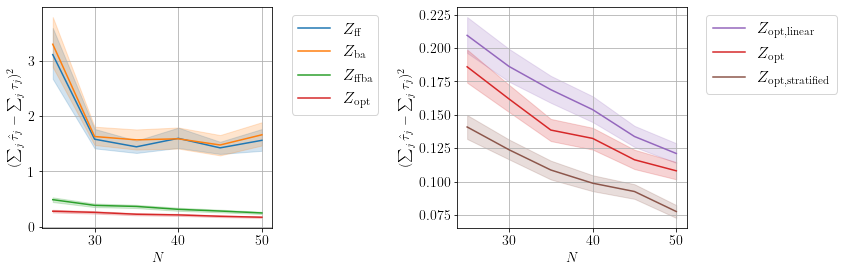

In [8]:
new_out_dir = "../flu/"
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

# make the left subplot
sns.lineplot(ax=axes[0], data=out_df_flu_basic, x=N_col, y=total_val_col, hue='$\mathrm{design}$',estimator=np.mean, err_style="band", palette=color_palette_dict)

axes[0].tick_params('x', labelrotation=360)
axes[0].set_xlabel(N_col)
axes[0].set_ylabel(total_val_col)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid()

# make the right subplot
sns.lineplot(ax=axes[1], data=out_df_flu_additional, x=N_col, y=total_val_col, hue='$\mathrm{design}$',estimator=np.mean, err_style="band", palette=color_palette_dict)

axes[1].tick_params('x', labelrotation=360)
axes[1].set_xlabel(N_col)
axes[1].set_ylabel(total_val_col)

axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid()
plt.tight_layout()

plt.savefig(out_dir+"flu/flu_T_"+str(T)+"_varying_N_lag_"+str(lag)+"_total-effect.pdf")